In [1]:
from vca_helper import *

In [2]:
! ls /data/jsaxon/zoom

a  a-prime  b  b-prime	zoom_api_logs


In [3]:
REPROCESS_PCAPS = False
if REPROCESS_PCAPS:
    
    a_pcap = get_pcap_csv(ip_addr["A"], "/data/jsaxon/zoom/a/captures/target-zoom-False*csv")
    a_pcap.to_csv("/data/jsaxon/zoom/a/captures.csv.gz", index = False)

    b_pcap_vca = get_pcap_csv(ip_addr["B"], "/data/jsaxon/zoom/b/*/*/*csv")
    b_pcap_streams = get_pcap_csv(ip_addr["B"], "/data/jsaxon/zoom/b/*/*csv")

    b_pcap = pd.concat([b_pcap_vca, b_pcap_streams])
    b_pcap.to_csv("/data/jsaxon/zoom/b/captures.csv.gz", index = False)

a_pcap = pd.read_csv("/data/jsaxon/zoom/a/captures.csv.gz")
b_pcap = pd.read_csv("/data/jsaxon/zoom/b/captures.csv.gz")

In [4]:
b_iperf  = get_iperf("/data/jsaxon/zoom/b/iperf3/reports/*json")
zoom_api = get_zoom_api(ip_addr["turris"], "/data/jsaxon/zoom/zoom_api_logs/*json")

/data/jsaxon/zoom/b/iperf3/reports/zoom-iperf-1619472011-100-0.75.json had no intervals


In [5]:
a_vars = ["ts", 
          "shape_dl", "shape_ul", "shape_latency", "shape_loss",
          "A", "A_browser", "pcap_dl_mbps", "pcap_ul_mbps"]
a_pcap_sel = a_pcap[a_vars].rename(columns = {"pcap_dl_mbps" : "a_pcap_dl_mbps", 
                                              "pcap_ul_mbps" : "a_pcap_ul_mbps"})
a_pcap_sel.sort_values("ts", inplace = True)

b_vars = ["ts", "B", "B_browser", "pcap_dl_mbps", "pcap_ul_mbps"]
b_pcap_sel = b_pcap[b_vars].rename(columns = {"pcap_dl_mbps" : "b_pcap_dl_mbps", 
                                              "pcap_ul_mbps" : "b_pcap_ul_mbps"})
b_pcap_sel.sort_values("ts", inplace = True)

b_iperf_sel = b_iperf[["ts", "iperf_mbps"]].rename(columns = {"iperf_mbps" : "b_iperf_mbps"})

for c in zoom_api.columns: 
    if c != "ts":
        zoom_api.rename(columns = {c : "zoom_" + c}, inplace = True)

In [6]:
zoom = a_pcap_sel.merge(b_pcap_sel,  on = "ts", how = "outer")\
                 .merge(b_iperf_sel, on = "ts", how = "outer")\
                 .merge(zoom_api,    on = "ts", how = "outer")

In [7]:
speed_vals = list(a_pcap.query("shape_dl < 100").shape_dl.sort_values().unique())

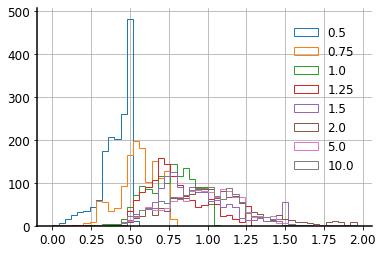

In [8]:
f, ax = plt.subplots()

for dl in speed_vals:
    a_pcap.query(f"shape_dl == {dl}").pcap_dl_mbps\
          .hist(histtype = "step", alpha = 1, 
                bins = np.arange(0,2, 0.04), 
                label = str(dl), ax = ax, )
    
ax.legend()

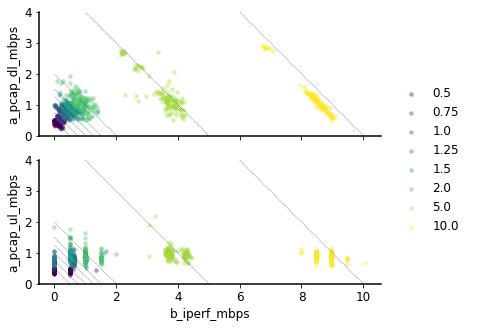

In [9]:
cmap = plt.get_cmap("viridis")

f, ax = plt.subplots(2, 1, figsize = (11, 5), 
                     sharex = True, subplot_kw = {"aspect" : 1})

for direc, axi in zip(["dl", "ul"], ax):

    speeds = zoom.query("~b_iperf_mbps.isna()")

    for bw_i, bw in enumerate(speed_vals):

        c = cmap(bw_i / (len(speed_vals) - 1))
        label = bw if axi == ax[-1] else None
        
        speeds.query(f"{bw} == shape_" + direc)\
              .plot(x = "b_iperf_mbps", y = f"a_pcap_{direc}_mbps", kind = "scatter", 
                    color = c, lw = 0, alpha = 0.4, label = label, ax = axi)

        axi.plot([bw, 0], [0, bw], color = "k", lw = 0.5, ls = ":")
        
        axi.set_ylim(0, 4)
        
    if axi == ax[-1]:
        axi.legend(loc = "center left", bbox_to_anchor = (1, 1))

f.savefig(f"iperf_scatter.pdf")

In [10]:
iperf_profile = \
zoom.query("~b_iperf_mbps.isna() & (shape_dl < 100)")\
    .groupby("shape_dl")[["a_pcap_dl_mbps", "b_iperf_mbps"]]\
    .median().rename(columns = {"a_pcap_dl_mbps" : "VCA", "b_iperf_mbps" : "Competing Flow"})

netflix_profile = \
zoom.query("B == 'netflix' & (shape_dl < 100)")\
    .groupby("shape_dl")[["a_pcap_dl_mbps", "b_pcap_dl_mbps"]]\
    .median().rename(columns = {"a_pcap_dl_mbps" : "VCA", "b_pcap_dl_mbps" : "Competing Flow"})

meet_profile = \
zoom.query("B == 'meet' & (shape_dl < 100)")\
    .groupby("shape_dl")[["a_pcap_dl_mbps", "b_pcap_dl_mbps"]]\
    .median().rename(columns = {"a_pcap_dl_mbps" : "VCA", "b_pcap_dl_mbps" : "Competing Flow"})

youtube_profile = \
zoom.query("B == 'youtube' & (shape_dl < 100)")\
    .groupby("shape_dl")[["a_pcap_dl_mbps", "b_pcap_dl_mbps"]]\
    .median().rename(columns = {"a_pcap_dl_mbps" : "VCA", "b_pcap_dl_mbps" : "Competing Flow"})


profiles = {"Meet" : meet_profile, "iperf" : iperf_profile, 
            "Netflix" : netflix_profile, "YouTube" : youtube_profile}
colors   = {"Netflix" : "r", "iperf" : "k", "Meet" : "#5451CC", "YouTube" : "lime"}

In [11]:
for prof in profiles.values():

    prof["fr_vca"]       = prof["VCA"] / prof[["VCA", "Competing Flow"]].sum(axis = 1)
    prof["fr_competing"] = prof["Competing Flow"] / prof[["VCA", "Competing Flow"]].sum(axis = 1)
    prof["fr_vca_max"]   = prof["VCA"] / prof["VCA"].max()


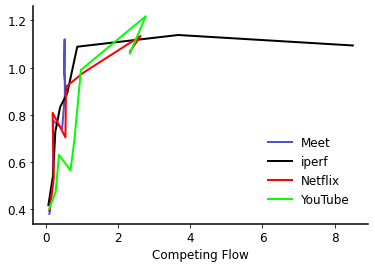

In [12]:
f, ax = plt.subplots()

args = {"x" : "Competing Flow" , "y" : "VCA", "ax" : ax}

for label, df in profiles.items():
    df.plot(label = label, color = colors[label], **args)

ax.legend()

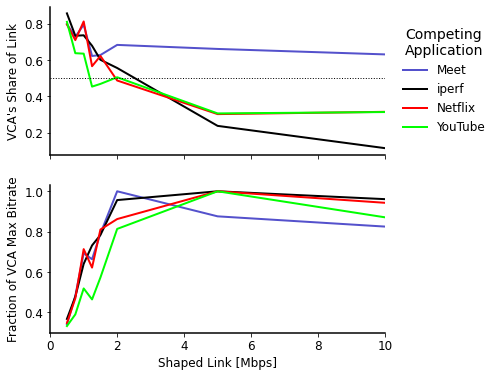

In [13]:
f, ax = plt.subplots(2, 1, figsize = (6, 6), sharex = True)

for label, df in profiles.items():
    df.fr_vca.plot(label = label, color = colors[label], ax = ax[0])
    df.fr_vca_max.plot(label = label, color = colors[label], ax = ax[1])
    
ax[0].plot([0, 10], [0.5, 0.5], color = "k", ls = ":", lw = 1)
    
ax[1].set_xlim(0, 10)
ax[1].set_xlabel("Shaped Link [Mbps]")
ax[0].set_ylabel("VCA's Share of Link")
ax[1].set_ylabel("Fraction of VCA Max Bitrate")

ax[0].legend(title = "Competing\nApplication", 
             loc = "center left", bbox_to_anchor = (1, 0.5))